A shape: (2000, 4)  y shape: (2000, 1)


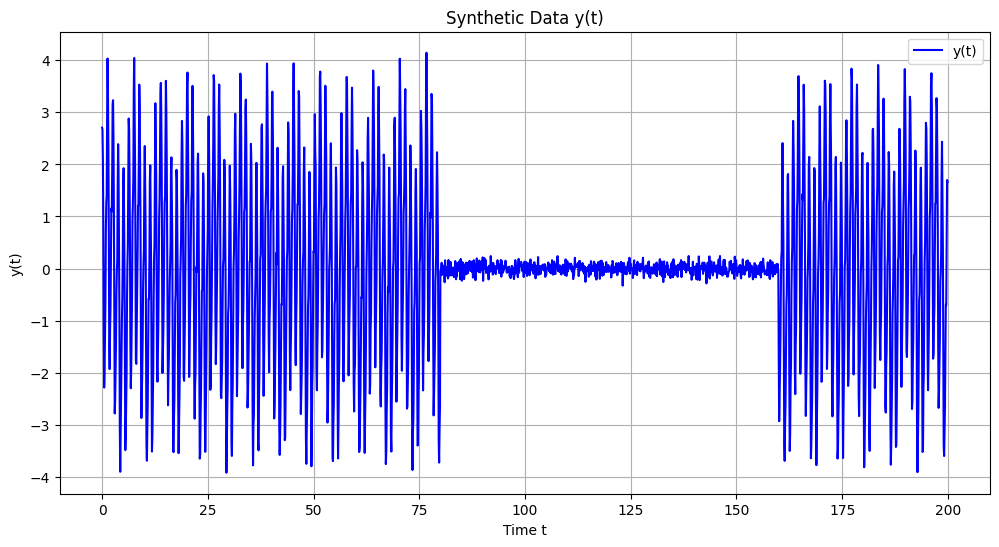

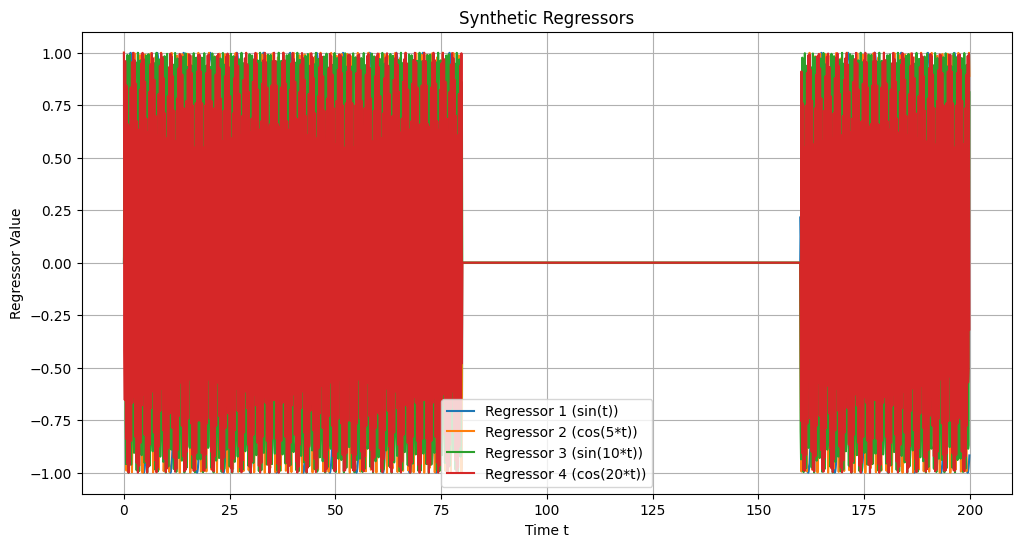

In [1]:
import pandas as pd
import numpy as np


# Generate synthetic data y(t) = theta_0 * sin(t) + theta_1 * cos(5 * t) + theta_2 * sin(10 * t) + theta_4 * cos(20 * t)
# For t < 80, y(t) is y(t), for  160 > t >= 80, y(t) is 0 and all regressors are 0, for t >= 160, y(t) is y(t) again

t = np.arange(0, 200, 0.1)

# Generate regressors
# for t < 80
regressor_1 = np.sin(t)
regressor_2 = np.cos(5 * t)
regressor_3 = np.sin(10 * t)
regressor_4 = np.cos(20 * t)

# for 80 <= t < 160
regressor_1[t >= 80] = 0
regressor_2[t >= 80] = 0
regressor_3[t >= 80] = 0
regressor_4[t >= 80] = 0

# for t >= 160
regressor_1[t >= 160] = np.sin(t[t >= 160])
regressor_2[t >= 160] = np.cos(5 * t[t >= 160])
regressor_3[t >= 160] = np.sin(10 * t[t >= 160])
regressor_4[t >= 160] = np.cos(20 * t[t >= 160])

# True coefficients
theta_0 = 1.0
theta_1 = 2.5
theta_2 = 0.7
theta_3 = 0.3

# matrix A
A = np.hstack((regressor_1.reshape(-1, 1),
               regressor_2.reshape(-1, 1),
               regressor_3.reshape(-1, 1),
               regressor_4.reshape(-1, 1)))
y = (theta_0 * regressor_1 +
     theta_1 * regressor_2 +
     theta_2 * regressor_3 +
     theta_3 * regressor_4).reshape(-1, 1) + np.random.normal(0, 0.1, size=(len(t), 1))

print("A shape:", A.shape, " y shape:", y.shape)

# Plot y
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(t, y, label='y(t)', color='blue')
plt.title('Synthetic Data y(t)')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.grid()
plt.legend()
plt.show()

# Plot regressors
plt.figure(figsize=(12, 6))
plt.plot(t, regressor_1, label='Regressor 1 (sin(t)) ')
plt.plot(t, regressor_2, label='Regressor 2 (cos(5*t))')
plt.plot(t, regressor_3, label='Regressor 3 (sin(10*t))')
plt.plot(t, regressor_4, label='Regressor 4 (cos(20*t))')
plt.title('Synthetic Regressors')
plt.xlabel('Time t')
plt.ylabel('Regressor Value')
plt.grid()
plt.legend()
plt.show()


In [2]:

# WEIGHT RLS


def weighted_rls_step(theta, P, row, y_t, beta):
    """
    Weighted RLS 单步更新
    theta: 当前参数向量 (p, 1)
    P: 当前逆协方差矩阵 (p, p)
    row: 当前样本 (p, 1)
    y_t: 当前目标值 (float)
    beta: 遗忘因子
    """
    newsample = row @ row.T
    theta = theta + (P @ row) * (y_t - row.T @ theta) / (beta + row.T @ P @ row)
    P = 1/beta * (P - (P @ newsample @ P) / (beta + row.T @ P @ row))
    return theta, P


In [3]:
def nlms_step(theta, row, y_t, eta=0.1):
    """
    NLMS 单步更新
    theta: 当前参数向量 (p, 1)
    row: 当前样本 (p, 1)
    y_t: 当前目标值 (float)
    eta: 学习率
    """
    theta = theta + ((eta * row) * (y_t - row.T @ theta)) / (1 + eta * row.T @ row)
    return theta


⚠ Step 1600: 条件数 11205478684671644.00 > 200，重置 P
RMSE: 0.1196
R²   : 0.9964


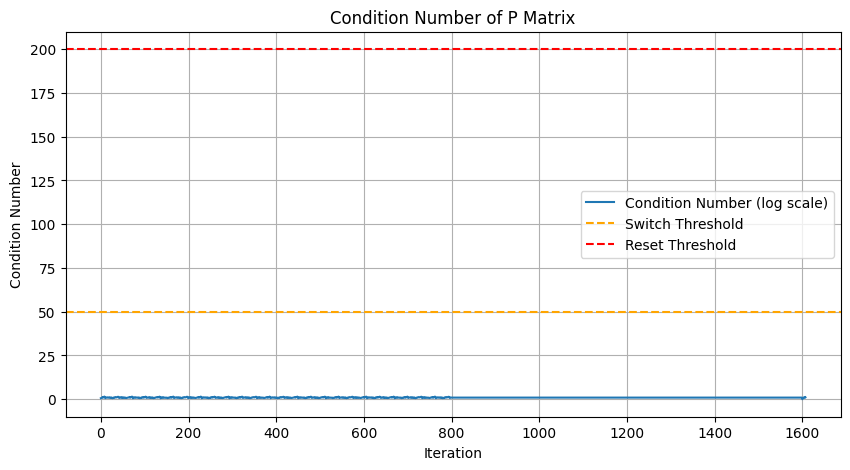

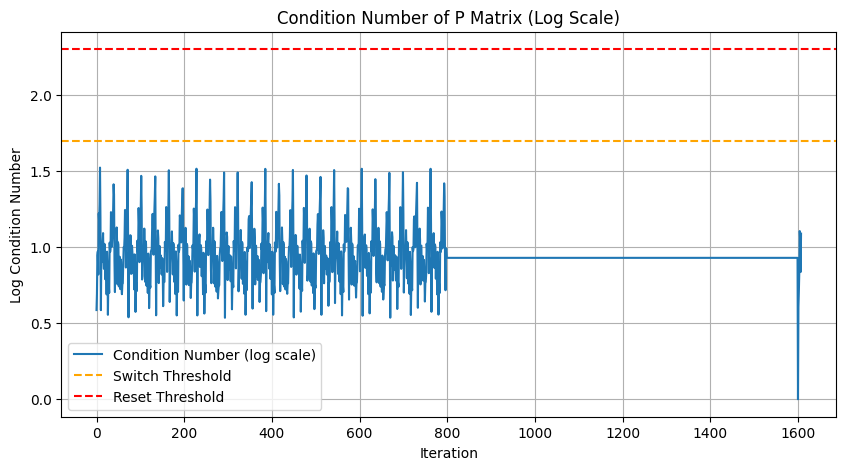

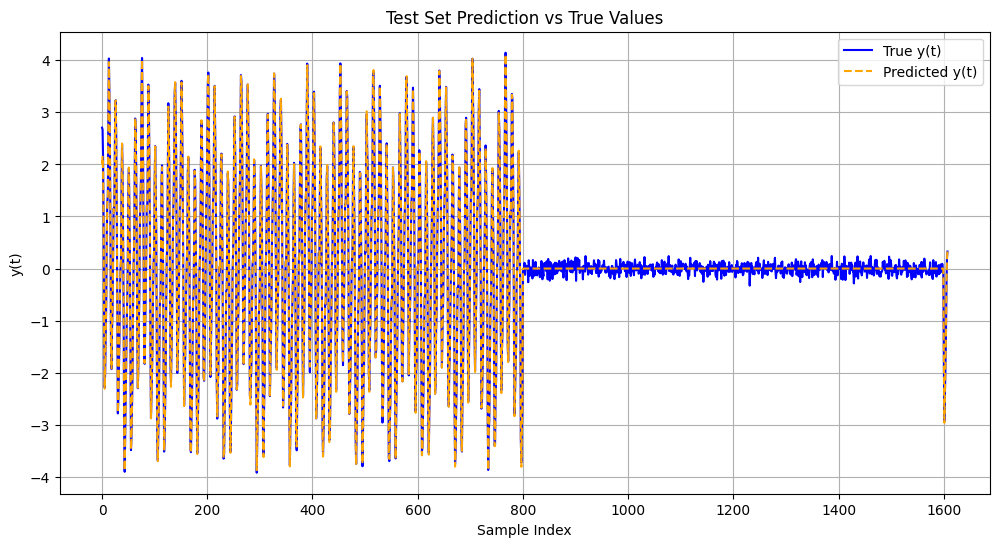

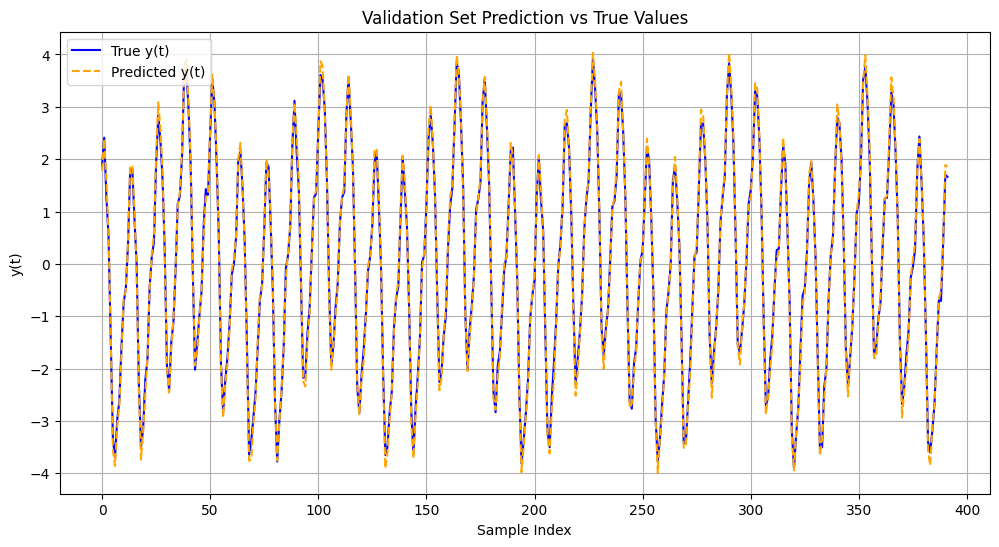

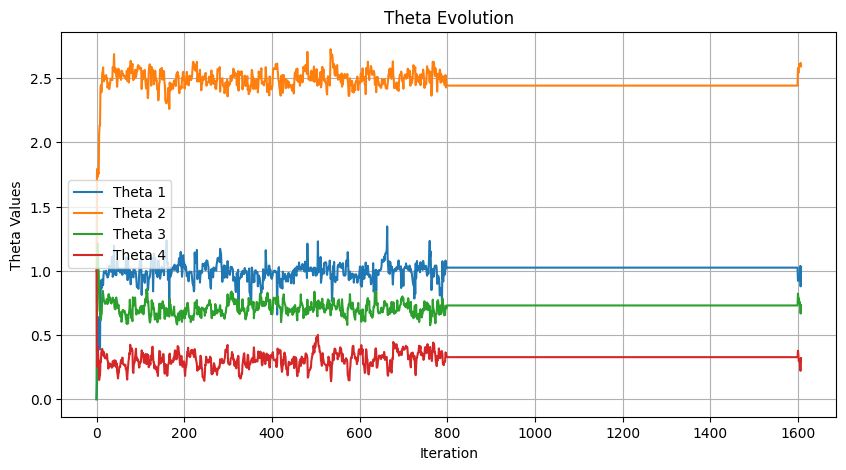

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


n = A.shape[0]
split_idx = int(n * 0.804)
A_train, A_test = A[:split_idx], A[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ==== 初始化 ====
beta = 0.7
eta = 0.1
cond_thresh_switch = 50     # 切换到 NLMS
cond_thresh_reset = 200  # P 重置条件

enable_switch = True  # 是否启用切换Hybrid逻辑
use_nlms = False
cond_list = []
mode_list = []

P = np.identity(A_train.shape[1])
P_reset = np.identity(A_train.shape[1])
theta_rls = np.zeros((A_train.shape[1], 1))   # RLS 参数
theta_nlms = np.zeros((A_train.shape[1], 1))  # NLMS 参数
theta = np.zeros((A_train.shape[1], 1))  # 当前主预测器参数

theta_list = []
pred_y_list = []

# ==== 循环 ====
for i, (row, y_t) in enumerate(zip(A_train, y_train.flatten())):
    row = row.reshape(-1, 1)

    # ---- RLS 后台持续更新 ----
    theta_rls, P = weighted_rls_step(theta_rls, P, row, y_t, beta)
    cond_num = np.linalg.cond(P)

    if enable_switch:
        # ---- 检查 P 是否需要重置 ----
        if cond_num > cond_thresh_reset:
            print(f"⚠ Step {i}: 条件数 {cond_num:.2f} > {cond_thresh_reset}，重置 P")
            P = P_reset
            cond_num = 1.0  # 重置后条件数

        # ---- 切换逻辑 ----
        if not use_nlms and cond_num > cond_thresh_switch:
            print(f"⚠ Step {i}: 条件数 {cond_num:.2f} > {cond_thresh_switch}，切到 NLMS")
            use_nlms = True

        elif use_nlms and cond_num < cond_thresh_switch:
            print(f"ℹ Step {i}: 条件数 {cond_num:.2f} < {cond_thresh_switch}，切回 RLS")
            use_nlms = False

        # ---- 主预测器更新 ----
        if use_nlms:
            theta_nlms = nlms_step(theta_nlms, row, y_t, eta)
            theta = theta_nlms
            mode_list.append("NLMS")
        else:
            theta = theta_rls
            mode_list.append("RLS")

    else:
        # 如果不启用切换逻辑，始终使用 RLS
        theta = theta_rls
        mode_list.append("RLS")

    cond_list.append(cond_num)
    theta_list.append(theta.flatten())
    pred_y_list.append((row.T @ theta).flatten())

# ==== 测试集预测 ====
y_pred_test = A_test @ theta

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# ==== 条件数曲线 ==== Use log y scale
plt.figure(figsize=(10, 5))
plt.plot(np.log10(cond_list), label="Condition Number (log scale)")
plt.axhline(cond_thresh_switch, color='orange', linestyle='--', label='Switch Threshold')
plt.axhline(cond_thresh_reset, color='red', linestyle='--', label='Reset Threshold')
plt.title("Condition Number of P Matrix")
plt.xlabel("Iteration")
plt.ylabel("Condition Number")
plt.legend()
plt.grid(True)
plt.show()

# Use log y scale to plot condition number only
plt.figure(figsize=(10, 5))
plt.plot(np.log10(cond_list), label="Condition Number (log scale)")
plt.axhline(np.log10(cond_thresh_switch), color='orange', linestyle='--', label='Switch Threshold')
plt.axhline(np.log10(cond_thresh_reset), color='red', linestyle='--', label='Reset Threshold')
plt.title("Condition Number of P Matrix (Log Scale)")
plt.xlabel("Iteration")
plt.ylabel("Log Condition Number")
plt.legend()
plt.grid(True)
plt.show()


# ==== Train 对比图 ====
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='True y(t)', color='blue')
plt.plot(pred_y_list, label='Predicted y(t)', color='orange', linestyle='--')
plt.title('Test Set Prediction vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('y(t)')
plt.legend()
plt.grid()
plt.show()

# Validation comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True y(t)', color='blue')
plt.plot(y_pred_test, label='Predicted y(t)', color='orange', linestyle='--')
plt.title('Validation Set Prediction vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('y(t)')
plt.legend()
plt.grid()
plt.show()

# Plot theta evolution
import matplotlib.pyplot as plt
theta_array = np.array(theta_list)
plt.figure(figsize=(10, 5))
plt.plot(theta_array)
plt.title("Theta Evolution")
plt.xlabel("Iteration")
plt.ylabel("Theta Values")
plt.legend([f"Theta {i+1}" for i in range(theta_array.shape[1])])
plt.grid(True)
plt.show()  